In [3]:
from scipy.optimize import linprog
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt

from gurobi import *

### Define some utility pairings based on a scenario

In [88]:
def generate_utility_pairings(I,T):
    '''Create a dummy scenario statisfying valid weight properties'''
    impatient = np.random.rand(T,I+1) 
    patient = np.random.rand(I,I+1)
    
    patient[:,0] = -1
    
    #make a few paris non-compatible
    pairing_weights = np.concatenate((impatient, patient), axis=0)
    for i in range(I+T):
        i,j = np.random.randint(0,I+T), np.random.randint(1,I+1)
        pairing_weights[i,j] = -1
    
    #make patient-patient pairings symmetric
    pairing_weights[T:,1:] = np.maximum(pairing_weights[T:,1:], pairing_weights[T:,1:].T)
    pairing_weights[T:,1:][np.eye(I,dtype=bool)] = -1
    
    return pairing_weights

### Now define several functions to convert our problem formulation to standard matrix form

In [117]:
def make_primal_constraint_matrix(I, T, c_len, pairing_weights):
    constraints = np.zeros((T*I+I, c_len))
    for a in range(0, T):
        for b in range(0,I):
            constraint = np.zeros(pairing_weights.shape)
            constraint[a, :] = 1
            constraint[:,b+1] = 1
            constraints[a*I+b,:] = constraint.reshape(constraint.shape[0] * constraint.shape[1])

    for B in range(0, I):
        constraint = np.zeros(pairing_weights.shape)
        constraint[B+T, 1:] += 1
        constraint[:, B+1] += 1
        constraints[T*I+B,:] = constraint.reshape(constraint.shape[0] * constraint.shape[1])
    
    return constraints



In [90]:
T = 2 #impatient agents
I = 2 #patient agents

pairing_weights = generate_utility_pairings(I,T)


c = -1 * pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1])
constraints = make_primal_constraint_matrix(I, T, len(c), pairing_weights)
b = np.ones((constraints.shape[0],1))

### Scipy solvers 

In [36]:
def calculate_primal_solns_scipy(pairing_weights, I, T):

    c = -1 * pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1])
    constraints = make_primal_constraint_matrix(I, T, len(c), pairing_weights)
    b = np.ones((constraints.shape[0],1))

    solved_program = linprog(c, constraints, b)
    pairings = solved_program.x.reshape(pairing_weights.shape)
    utility_p = -1 * solved_program.fun
    
    return utility_p, pairings

def calculate_dual_solns_scipy(pairing_weights, I, T):

    constraints_d, inequalities_d = make_dual_constraint_matrix(I, T, pairing_weights)
    c_d = np.ones((T+I))

    solved_program = linprog(c_d, constraints_d, inequalities_d)
    coefficients = solved_program.x
    utility_d = solved_program.fun
    
    if solved_program.success == False:
        print(solved_program.message)
    
    return utility_d, coefficients

### Find optimal pairings & utility based on the primal. Find optimal coefficients & utility based on the dual

In [37]:
def in_constraint(v):
    if v[1]:
        return True
    else:
        return False

def calculate_primal_solns_gurobi(pairing_weights, I, T):
    m = Model("dynamicmatch_primal")
    m.modelSense = GRB.MAXIMIZE
    m.setParam( 'OutputFlag', False )

    weights = pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1])
    c = -1 * pairing_weights.reshape(pairing_weights.shape[0] * pairing_weights.shape[1])
    constraints = make_primal_constraint_matrix(I, T, len(weights), pairing_weights)


    keys = range(constraints.shape[1])
    variables = m.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                     obj=weights,
                     name="primal",
                     lb=0)

    for constraint in constraints:
        m.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) <= 1)
    

    m.optimize()
    allocations = np.array([variables[var].X for var in variables]).reshape(pairing_weights.shape)
    m.write('constraint.lp')

    return m.objVal, allocations

def calculate_dual_solns_gurobi(pairing_weights, I, T):

    md = Model("dynamicmatch_dual")
    md.modelSense = GRB.MINIMIZE
    md.setParam( 'OutputFlag', False )
    
    md.setParam( 'OutputFlag', False )
    constraints_d, inequalities_d = make_dual_constraint_matrix(I, T, pairing_weights)
    c_d = np.ones((T+I))

    keys = range(constraints_d.shape[1])
    variables = md.addVars(keys,
                    vtype=GRB.CONTINUOUS,
                    obj=c_d,
                    name="dual",
                    lb=0)

    for cix, constraint in enumerate(constraints_d):
        md.addConstr(sum(variables[o]*c for o,c in filter(in_constraint, zip(variables,constraint))) <= inequalities_d[cix])

    md.optimize()

    betas = np.array([variables[var].X for var in variables][T:])
    betas = np.insert(betas, 0, 0)
    alphas = np.array([variables[var].X for var in variables][:T])
    return md.objVal, alphas, betas

# Implement online assignment algorithm

# Running the solvers

In [113]:
T = 5 #impatient agents
I = 3 #patient agents

pairing_weights = generate_utility_pairings(I,T)

### Gurobi solver

In [118]:
upg, pairingg = calculate_primal_solns_gurobi(pairing_weights, I, T)
# udg, alphas, betas = calculate_dual_solns_gurobi(pairing_weights, I, T)

print(upg)
print(pairingg)

2.1990911504220616
[[0.66666667 0.         0.         0.        ]
 [0.66666667 0.         0.         0.        ]
 [0.66666667 0.         0.         0.        ]
 [0.66666667 0.         0.         0.        ]
 [0.66666667 0.         0.         0.        ]
 [0.         0.         0.33333333 0.33333333]
 [0.         0.         0.         0.        ]
 [0.         0.33333333 0.         0.        ]]


In [87]:
upg, pairingg = calculate_primal_solns_gurobi(pairing_weights, I, T)
# udg, alphas, betas = calculate_dual_solns_gurobi(pairing_weights, I, T)

print(upg)
print(pairingg)

2.605653480974901
[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [1. 0. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


### Scipy solver

In [108]:
utility_p, pairings = calculate_primal_solns_scipy(pairing_weights, I, T)
utility_d, coeffs = calculate_dual_solns_scipy(pairing_weights, I, T)
print(utility_d)
print(utility_p)
print(pairings)

1.9160315086884125
1.9160315086884125
[[1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [1.  0.  0.  0. ]
 [0.  0.5 0.  0. ]
 [0.  0.  0.  1. ]
 [0.  0.  0.  0. ]]


# Testing
- Iterate over different patient/impatient scenarios and validate primal & dual produce same utility

### Check that primal and dual solutions generated by Gurobi are equivilant

In [ ]:
for R in range(30,50):
    for S in range(30,50):
        pairing_weights = generate_utility_pairings(R,S)
        utility_1, _ = calculate_primal_solns_gurobi(pairing_weights, R, S)
        utility_2, _ = calculate_dual_solns_gurobi(pairing_weights, R, S)
        assert round(utility_1, 11) == round(utility_2, 11), "Dual and Primal solutions are not equivilant"

### Check online dual assignment solution

Run several simple simulations to see how frequent ties are, and the discrepancy from the optimal utility

- Between 30 and 40 patient agents (increments of 5)
- Between 30 and 40 impatient agents

In [361]:
utility_discrepencies = []
nties = []

for R in range(30,50,5):
    for S in range(30,40):
        pairing_weights = generate_utility_pairings(R,S)
        utility_g, alphas, betas = calculate_dual_solns_gurobi(pairing_weights, R, S)
        utility_o, _, ties = online_dual_assignment(alphas, betas, pairing_weights, R, S)
        
        diff = np.abs(utility_g - utility_o) / ((utility_g + utility_o) / 2) * 100
        
        utility_discrepencies.append(diff)
        nties.append(ties)
        
        assert utility_g > utility_o, "Online utility is greater than optimal"
        assert utility_g == utility_o or ties > 0, "Utility does not match, but there are no ties"
                     

### Number of ties being generated in various scenarios

Average number of ties:  11.775


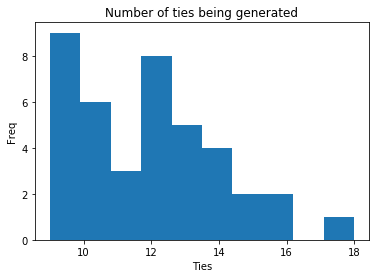

In [362]:
print('Average number of ties: ', np.mean(nties))

f = plt.figure()
plt.hist(nties)
plt.gca().set(title='Number of ties being generated', ylabel='Freq',xlabel='Ties');

Average percent difference between optimal and allocated utility: 2.465668050444207%


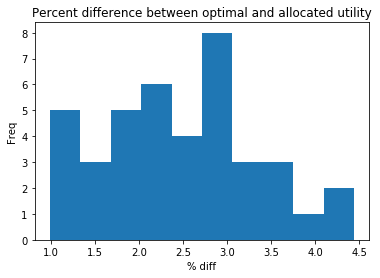

In [363]:
print("Average percent difference between optimal and allocated utility: {}%".format(np.mean(utility_discrepencies)))

plt.hist(utility_discrepencies)
plt.gca().set(title='Percent difference between optimal and allocated utility', ylabel='Freq',xlabel='% diff');